In [31]:
import torch
import pickle
import os.path as osp
from qm9 import utils as qm9_utils

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
names = locals()
# dir = "/work/01/gq54/p23002/guyuhan/wisteria_guyuhan/data_preprocess/805_Alchemy9_for_schnet.npz"
dir = "/work/01/gq54/p23002/guyuhan/wisteria_guyuhan/dimenet_used/data/qm9_eV.npz"
data=np.load(dir)
print(data.files)
prop = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
        'zpve', 'U0', 'U','H', 'G', 'Cv' ]
split = [data['N'][0]]
for i in tqdm(range(len(data['N'])-2)):
        split.append(split[-1] + data['N'][i + 1])
print(len(split))
num_atoms_split = data['N']
max = num_atoms_split.max()
charges_split = np.split(data['Z'],split)
charge_scale = data['Z'].max()
positions_split = np.split(data['R'],split)
index_split = data['id']
for _ in prop:
        names[_ + '_split'] = data[_]

dict_keys1 =  ['index','num_atoms', 
        'mu', 'alpha', 'homo', 'lumo', 
        'gap', 'r2', 'zpve', 'U0', 
        'U', 'H', 'G', 'Cv',]
dict_keys2 = ['charges', 'positions',]

dict_keys3 = ['one_hot', 'atom_mask', 'edge_mask']

all_species = torch.tensor(data['Z']).unique(sorted=True)
if all_species[0] == 0:
        all_species = all_species[1:]
included_species = all_species
included_species.shape
n = 100

['R', 'N', 'Z', 'id', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'meta']


100%|██████████| 130829/130829 [02:41<00:00, 812.00it/s]


130830


In [32]:
for i in range(n):
    dict_i = {}
    # dict_i['charges'] = torch.tensor(_)
    _ = np.pad(charges_split[i],((0), (max - charges_split[i].size)),'constant')
    dict_i['charges'] = torch.tensor(_)
    if i == 0:
        all_charges = dict_i['charges'].unsqueeze(0)
    else:
        all_charges = torch.cat((all_charges,dict_i['charges'].unsqueeze(0)),0)


In [33]:
all_one_hot = all_charges.unsqueeze(-1) == included_species.unsqueeze(0).unsqueeze(0)
print(all_one_hot.shape)
dataset_alchemy = []

for i in range(n):
    dict_i = {}
    for _ in dict_keys1:
        dict_i[_] = torch.tensor(names[_ + '_split'][i])
    _ = np.pad(charges_split[i],((0), (max - charges_split[i].size)),'constant')
    dict_i['charges'] = torch.tensor(_)
    if i == 0:
        all_charges = dict_i['charges'].unsqueeze(0)
    else:
        all_charges = torch.cat((all_charges,dict_i['charges'].unsqueeze(0)),0)
    _ = np.pad(positions_split[i],((0,max - positions_split[i].shape[0]), (0,0)),'constant')
    dict_i['positions'] = torch.tensor(_)
    # dict_i['one_hot'] = dict_i['charges'].unsqueeze(-1) == included_species.unsqueeze(0).unsqueeze(0)
    dict_i['one_hot'] = all_one_hot[i]
    dataset_alchemy.append(dict_i)

torch.Size([100, 29, 5])


In [34]:
class al_dataset(Dataset):
    def  __init__(self,name):
        self.set = name
        
    def __len__(self):
        return len(dataset_alchemy)
    
    def __getitem__(self, idx):
        return self.set[idx]

al9_set = al_dataset(dataset_alchemy)

In [77]:
from qm9.data.collate import collate_fn
dataloaders = {'altest': DataLoader(al9_set,
                                     batch_size=96,
                                     shuffle=False if (split == 'train') else False,
                                     num_workers=2,
                                     collate_fn=collate_fn)
                        }

In [80]:
from qm9.models import EGNN
best_model = torch.load('/work/01/gq54/p23002/egnn_homo/exp_1_homo/best_model',map_location='cpu')
device = 'cpu'
dtype = torch.float32
model = EGNN(in_node_nf=15, in_edge_nf=0, hidden_nf=128, device=device, n_layers=7, coords_weight=1.0,
             attention=1, node_attr=0)
model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [110]:
pred_all = [] 
from qm9 import dataset

# dataloaders, charge_scale = dataset.retrieve_dataloaders(96,2)

for i, data in enumerate(dataloaders['altest']):
        model.eval()
        batch_size, n_nodes, _ = data['positions'].size()
        atom_positions = data['positions'].view(batch_size * n_nodes, -1).to(device, dtype)
        atom_mask = data['atom_mask'].view(batch_size * n_nodes, -1).to(device, dtype)
        edge_mask = data['edge_mask'].to(device, dtype)
        one_hot = data['one_hot'].to(device, dtype)
        charges = data['charges'].to(device, dtype)
        nodes = qm9_utils.preprocess_input(one_hot, charges, 2, charge_scale, device)
        nodes = nodes.view(batch_size * n_nodes, -1)
        # nodes = torch.cat([one_hot, charges], dim=1)
        edges = qm9_utils.get_adj_matrix(n_nodes, batch_size, device)
        # label = data[args.property].to(device, dtype)
        pred = model(h0=nodes, x=atom_positions, edges=edges, edge_attr=None, node_mask=atom_mask, edge_mask=edge_mask,
                     n_nodes=n_nodes)
        break
        # pred_all.append(pred)


KeyError: 'altest'

In [83]:
dir = "/work/01/gq54/p23002/guyuhan/wisteria_guyuhan/data_preprocess/805_Alchemy9_for_schnet.npz"
# dir = "/work/01/gq54/p23002/guyuhan/wisteria_guyuhan/dimenet_used/data/qm9_eV.npz"
data=np.load(dir)
a = torch.tensor(data['lumo'][0:96])

In [26]:
best_model['best_val']

0.02754731423664206

In [93]:
pred = pred.detach().numpy()

In [91]:
homo = np.array(data['homo'])

In [94]:
np.corrcoef(pred,homo)

array([[1.        , 0.99636051],
       [0.99636051, 1.        ]])

In [101]:
dataloaders, charge_scale = dataset.retrieve_dataloaders(96, 2)
meann, mad = qm9_utils.compute_mean_mad(dataloaders, 'homo')

datasets type: <class 'dict'>
datasets train: <class 'qm9.data.dataset.ProcessedDataset'>
data type in datasets train: <class 'dict'>
dict_keys(['num_atoms', 'charges', 'positions', 'index', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'omega1', 'zpve_thermo', 'U0_thermo', 'U_thermo', 'H_thermo', 'G_thermo', 'Cv_thermo', 'one_hot'])
num_atoms torch.Size([])
charges torch.Size([29])
positions torch.Size([29, 3])
index torch.Size([])
A torch.Size([])
B torch.Size([])
C torch.Size([])
mu torch.Size([])
alpha torch.Size([])
homo torch.Size([])
lumo torch.Size([])
gap torch.Size([])
r2 torch.Size([])
zpve torch.Size([])
U0 torch.Size([])
U torch.Size([])
H torch.Size([])
G torch.Size([])
Cv torch.Size([])
omega1 torch.Size([])
zpve_thermo torch.Size([])
U0_thermo torch.Size([])
U_thermo torch.Size([])
H_thermo torch.Size([])
G_thermo torch.Size([])
Cv_thermo torch.Size([])
one_hot torch.Size([29, 5])


In [106]:
abs(pred*0.4405 -6.5369 - homo).mean()

0.01488416708213051

In [105]:
mad

tensor(0.4405)

TypeError: 'numpy.int64' object is not callable

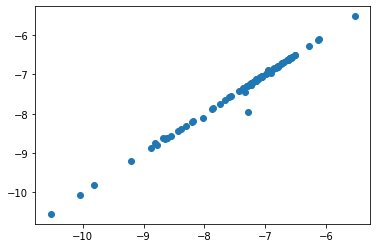

In [109]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pred*0.4405 -6.5369, homo)

# Add the y=x line
lim = [min(ax.get_xlim() + ax.get_ylim()), max(ax.get_xlim() + ax.get_ylim())]
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, 'k--')

# ax.set_xlabel(result_name + ' Label')
# ax.set_ylabel('dimenetpp Pred')
# name=result_name.split('/')[-1].split('.')[0]
# ax.set_title(name)
fig.set_size_inches(5 * 4,5)
fig.tight_layout()